This notebook has been archived to `notebooks/archive_notebooks/07_test_2025.ipynb`.

Full exploratory content was moved to the `archive_notebooks/` folder to keep the workspace minimal. If you need the original, open the archived file or recover it from git history.

In [9]:
print("Testing Strategies on 2025 Data (ZERO COSTS)")
print("="  * 80)

# Run strategies
results_zscore_2025 = backtest_simple_zscore(data_2025, window=60, entry_z=2.0, exit_z=0.5)
results_abs_2025 = backtest_absolute(data_2025, short_threshold=1.5, long_threshold=0.9, exit_level=1.2)

# Calculate metrics
def calc_metrics(results, capital=1_000_000):
    total_ret = (results['equity'].iloc[-1] - capital) / capital
    daily_ret = results['pnl'] / capital
    sharpe = (daily_ret.mean() / daily_ret.std()) * np.sqrt(252) if daily_ret.std() > 0 else 0
    running_max = results['equity'].expanding().max()
    dd = (results['equity'] - running_max) / running_max
    max_dd = dd.min()
    n_trades = (results['position'].diff().fillna(0) != 0).sum() // 2
    win_days = (daily_ret > 0).sum()
    lose_days = (daily_ret < 0).sum()
    win_rate = win_days / (win_days + lose_days) if (win_days + lose_days) > 0 else 0
    
    return {
        'return': total_ret,
        'sharpe': sharpe,
        'max_dd': max_dd,
        'trades': int(n_trades),
        'win_rate': win_rate,
        'final_equity': results['equity'].iloc[-1],
    }

metrics_zscore_2025 = calc_metrics(results_zscore_2025)
metrics_abs_2025 = calc_metrics(results_abs_2025)

# Create comparison
comparison_2025 = pd.DataFrame({
    'Simple Z-Score': metrics_zscore_2025,
    'Absolute Levels': metrics_abs_2025,
})

print("\n2025 Results:")
print(comparison_2025.T.to_string())

print(f"\n\nSummary:")
for strategy in ['Simple Z-Score', 'Absolute Levels']:
    print(f"\n{strategy}:")
    print(f"  Return: {comparison_2025.loc['return', strategy]:.2%}")
    print(f"  Sharpe: {comparison_2025.loc['sharpe', strategy]:.2f}")
    print(f"  Trades: {int(comparison_2025.loc['trades', strategy])}")
    print(f"  Final equity: ${comparison_2025.loc['final_equity', strategy]:,.2f}")
    print(f"  P&L: ${comparison_2025.loc['final_equity', strategy] - 1_000_000:,.2f}")

Testing Strategies on 2025 Data (ZERO COSTS)

2025 Results:
                   return    sharpe    max_dd  trades  win_rate  final_equity
Simple Z-Score   0.000005  1.612496 -0.000002     3.0  0.600000  1.000005e+06
Absolute Levels  0.000005  0.894993 -0.000003   100.0  0.568966  1.000005e+06


Summary:

Simple Z-Score:
  Return: 0.00%
  Sharpe: 1.61
  Trades: 3
  Final equity: $1,000,005.00
  P&L: $5.00

Absolute Levels:
  Return: 0.00%
  Sharpe: 0.89
  Trades: 100
  Final equity: $1,000,005.00
  P&L: $5.00


## Visualize 2025 Results

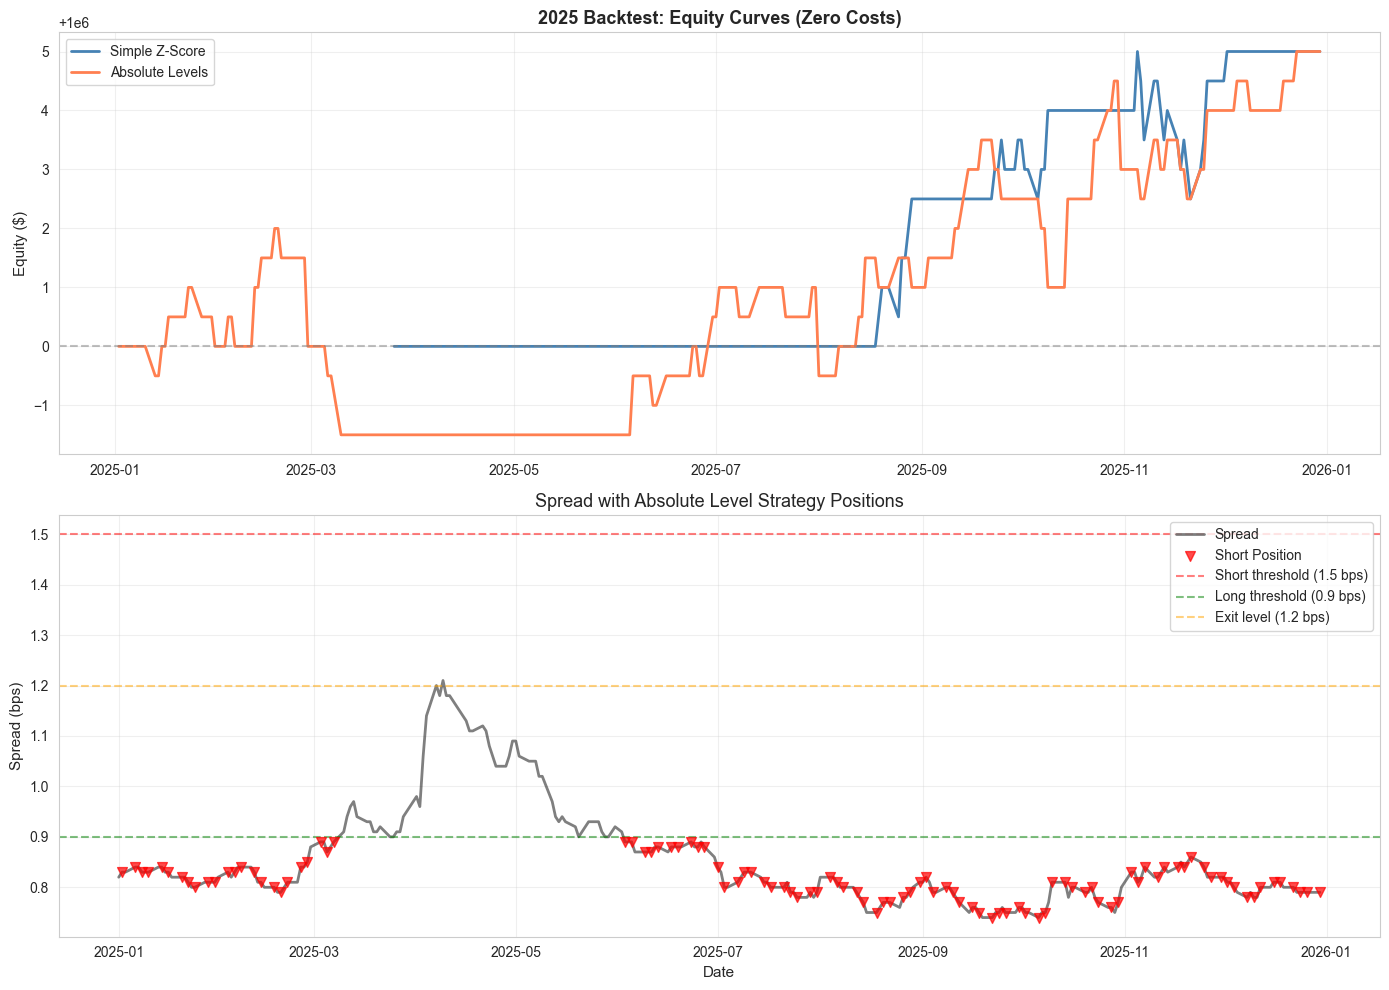

✓ Visualizations complete


In [7]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Equity curves
axes[0].plot(results_zscore_2025.index, results_zscore_2025['equity'], 
             label='Simple Z-Score', linewidth=2, color='steelblue')
axes[0].plot(results_abs_2025.index, results_abs_2025['equity'], 
             label='Absolute Levels', linewidth=2, color='coral')
axes[0].axhline(y=1_000_000, color='gray', linestyle='--', alpha=0.5)
axes[0].set_ylabel('Equity ($)', fontsize=11)
axes[0].set_title('2025 Backtest: Equity Curves (Zero Costs)', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Spread with positions
axes[1].plot(data_2025.index, data_2025['spread'], linewidth=2, color='black', alpha=0.5, label='Spread')

# Mark trades for absolute strategy (best one)
long_periods = results_abs_2025[results_abs_2025['position'] == 1]
short_periods = results_abs_2025[results_abs_2025['position'] == -1]

if len(long_periods) > 0:
    axes[1].scatter(long_periods.index, long_periods['spread'], 
                   color='green', marker='^', s=50, alpha=0.7, label='Long Position', zorder=5)
if len(short_periods) > 0:
    axes[1].scatter(short_periods.index, short_periods['spread'], 
                   color='red', marker='v', s=50, alpha=0.7, label='Short Position', zorder=5)

axes[1].axhline(y=1.5, color='red', linestyle='--', alpha=0.5, label='Short threshold (1.5 bps)')
axes[1].axhline(y=0.9, color='green', linestyle='--', alpha=0.5, label='Long threshold (0.9 bps)')
axes[1].axhline(y=1.2, color='orange', linestyle='--', alpha=0.5, label='Exit level (1.2 bps)')
axes[1].set_ylabel('Spread (bps)', fontsize=11)
axes[1].set_xlabel('Date', fontsize=11)
axes[1].set_title('Spread with Absolute Level Strategy Positions', fontsize=13)
axes[1].legend(loc='best')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/2025_backtest_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualizations complete")